# Subjectivity classification: SVM & hyperparameter optimisation

# Data Processing & parameters

In [23]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from sklearn.svm import SVC

articles = pd.read_csv('datasets/SportsArticles/features.csv')
display(articles.head())

,TextID,URL,Label,totalWordsCount,semanticobjscore,semanticsubjscore,CC,CD,DT,EX,...,pronouns2nd,pronouns3rd,compsupadjadv,past,imperative,present3rd,present1st2nd,sentence1st,sentencelast,txtcomplexity
0,Text0001,http://msn.foxsports.com/foxsoccer/mexico/stor...,objective,109,0,1,7,9,0,5,...,0,3,0,11,0,0,0,0,1,18
1,Text0002,http://msn.foxsports.com/foxsoccer/premierleag...,objective,309,21,4,1,19,1,4,...,0,10,0,13,0,14,9,1,1,14
2,Text0003,http://uk.eurosport.yahoo.com/04022011/58/fed-...,objective,149,6,1,8,14,0,5,...,0,2,0,8,0,3,2,1,1,18
3,Text0004,http://uk.eurosport.yahoo.com/07022011/58/bund...,objective,305,18,5,7,26,0,10,...,0,8,3,13,1,7,1,1,1,20
4,Text0005,http://uk.eurosport.yahoo.com/05022011/58/fed-...,objective,491,23,8,33,47,0,12,...,0,16,2,34,1,5,6,1,1,24


In [24]:
X_origin = articles.iloc[:,3:]
y_origin = articles.iloc[:,2]

#standardize data
X_standardized = preprocessing.scale(X_origin)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_standardized, y_origin, test_size=0.3, random_state=42)

In [25]:
# Initialising the hyperparameters and CV folds

k = ['poly', 'rbf', 'sigmoid']
c = [10**x for x in range(-5,5)]
g = [10**x for x in range(-5,5)]
parameters = {'kernel':k, 'C':c, 'gamma':g}

cv = KFold(n_splits=2, random_state=0, shuffle=False)

# Method 1: Single processing: original code

In [4]:
def svm_single(X_train, y_train, X_test, y_test, param, cv):
    '''
    Loops through the different parameter combinations and gets the best score
    X_train: training inputs
    y_train: training labels
    X_test: testing inputs
    y_test: testing outputs
    param: parameter dictionary that defines that parameter search space
    cv: KFolds
    '''
    from itertools import product
    import pandas as pd
    from sklearn import metrics
    from sklearn.svm import SVC
    from sklearn.model_selection import cross_val_score
    
    #initialise parameters
    scores = []
    max_score = -1 #starting point since a score cannot negative
    
    #create the cartesian product of the parameters to search over
    kernel_param = product(param['kernel'], param['C'], param['gamma'])
    
    #loop through every parameter combination
    for item in kernel_param:
        k = item[0]
        c = item[1]
        g = item[2]
        
        #initialise model
        model_svc = SVC(C= c, kernel=k, gamma=g)
        new_score = cross_val_score(model_svc, X_train, y_train, cv=cv)
        new_score_entry = [k, c, g, new_score.mean()]
        scores.append(new_score_entry)
        
        #if the score is greater than previous maximum score, keep as best parameter option
        if new_score.mean() > max_score:
            max_score = new_score.mean()
            max_score_param = new_score_entry
            
    
    #train and score model with best parameters
    model = SVC(kernel=max_score_param[0],C=max_score_param[1],gamma=max_score_param[2])
    model.fit(X_train,y_train)
    
    test_acc = model.score(X_test,y_test)
    print('Best model parameters:', max_score_param)
    print('Accuracy on test set:', test_acc)

    return max_score_param, scores, test_acc

In [5]:
result_single1 = svm_single(X_train1, y_train1, X_test1, y_test1, parameters, cv)

Best model parameters: ['sigmoid', 10000, 0.0001, 0.8328571428571429]
Accuracy on test set: 0.8233333333333334


## Benchmarking and Profiling

In [6]:
#let's do line profiling to see where the bottleneck is
%load_ext line_profiler
%lprun -f svm_single svm_single(X_train1, y_train1, X_test1, y_test1, parameters, cv)

Best model parameters: ['sigmoid', 10000, 0.0001, 0.8328571428571429]
Accuracy on test set: 0.8233333333333334


Timer unit: 1e-06 s

Total time: 12.221 s
File: <ipython-input-4-fe4c625be429>
Function: svm_single at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def svm_single(X_train, y_train, X_test, y_test, param, cv):
     2                                               '''
     3                                               Loops through the different parameter combinations and gets the best score
     4                                               X_train: training inputs
     5                                               y_train: training labels
     6                                               X_test: testing inputs
     7                                               y_test: testing outputs
     8                                               param: parameter dictionary that defines that parameter search space
     9                                               cv: KFolds
    10                              

In [26]:
#Let's increase the number of observations to see how it scales given this dataset is fairly small for a ML problem
#we create a timing function to be able to loop through and store the times
def time_function(f,*args):
    import datetime as dt
    start = dt.datetime.now()
    f_result = f(*args)
    end = dt.datetime.now()
    t = (end - start)
    print('Time it took to run:',t)
    return t, f_result


times_single_row = []
x = [n for n in range(1,10)]


for n in x:    
    #we don't care about the content of the new rows added, just the size of the data
    new_X_train = np.repeat(X_train1, n, axis = 0)
    new_y_train = np.repeat(y_train1, n)
    new_X_test = np.repeat(X_test1, n, axis = 0)
    new_y_test = np.repeat(y_test1, n)
    time_single, result_single = time_function(svm_single,new_X_train, new_y_train, new_X_test, new_y_test, parameters,cv)
    times_single_row.append(time_single)

Best model parameters: ['sigmoid', 10000, 0.0001, 0.8328571428571429]
Accuracy on test set: 0.8233333333333334
Time it took to run: 0:00:09.981062
Best model parameters: ['rbf', 100, 0.001, 0.8271428571428572]
Accuracy on test set: 0.8133333333333334
Time it took to run: 0:00:27.389682
Best model parameters: ['sigmoid', 1000, 0.0001, 0.8271428571428572]
Accuracy on test set: 0.8266666666666667
Time it took to run: 0:00:58.584471
Best model parameters: ['rbf', 100, 0.0001, 0.8242857142857143]
Accuracy on test set: 0.83
Time it took to run: 0:01:26.188518
Best model parameters: ['sigmoid', 0.1, 0.01, 0.8300000000000001]
Accuracy on test set: 0.7933333333333333
Time it took to run: 0:02:06.310930
Best model parameters: ['rbf', 0.1, 0.01, 0.8285714285714286]
Accuracy on test set: 0.8466666666666667
Time it took to run: 0:02:54.142832
Best model parameters: ['sigmoid', 10000, 1e-05, 0.8328571428571429]
Accuracy on test set: 0.82
Time it took to run: 0:04:08.131360
Best model parameters: ['s

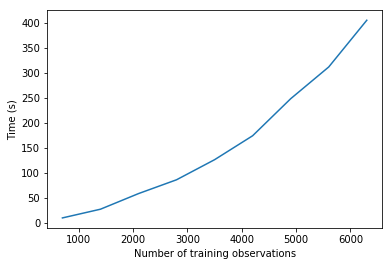

In [29]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

x = [n*700 for n in range(1,10)]
times_single_row = [(times_single_row[x].seconds + times_single_row[x].microseconds * 10**-6) for x in range(len(times_single_row))]
plt.plot(x, times_single_row)

plt.xlabel('Number of training observations')
plt.ylabel('Time (s)')
plt.savefig('img/Time_observations.png')
plt.show()


In [14]:
#how does it scale for number of features rather than observations?
times_single_col = []
x = [n for n in range(1,10)]

for n in x:    
    new_X_train = np.repeat(X_train1, n, axis = 1)
    new_X_test = np.repeat(X_test1, n, axis = 1)
    time_single, result_single = time_function(svm_single,new_X_train, y_train1, new_X_test, y_test1, parameters,cv)
    times_single_col.append(time_single)

Best model parameters: ['sigmoid', 10000, 0.0001, 0.8328571428571429]
Accuracy on test set: 0.8233333333333334
Time it took to run: 0:00:11.729790
Best model parameters: ['sigmoid', 10000, 0.0001, 0.8300000000000001]
Accuracy on test set: 0.8233333333333334
Time it took to run: 0:00:19.561066
Best model parameters: ['rbf', 10, 0.001, 0.8300000000000001]
Accuracy on test set: 0.82
Time it took to run: 0:00:26.043348
Best model parameters: ['rbf', 10, 0.001, 0.8285714285714286]
Accuracy on test set: 0.82
Time it took to run: 0:00:31.546924
Best model parameters: ['rbf', 100, 0.0001, 0.8271428571428572]
Accuracy on test set: 0.8433333333333334
Time it took to run: 0:00:41.812645
Best model parameters: ['sigmoid', 1, 0.001, 0.8371428571428572]
Accuracy on test set: 0.8033333333333333
Time it took to run: 0:00:45.294922
Best model parameters: ['sigmoid', 1, 0.001, 0.8385714285714285]
Accuracy on test set: 0.7933333333333333
Time it took to run: 0:00:55.922152
Best model parameters: ['rbf', 

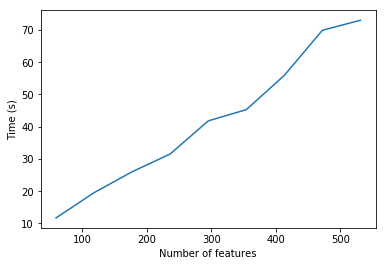

In [203]:
x = [n*59 for n in range(1,10)]
times_single_col = [(times_single_col[x].seconds + times_single_col[x].microseconds * 10**-6) for x in range(len(times_single_col))]
plt.plot(x, times_single_col)

plt.xlabel('Number of features') #change label
plt.ylabel('Time (s)')
plt.savefig('img/Time_features.png')
plt.show()

# Method 1: Single-processing (server)

We created a .py version to run on the server so we can compare results with Method 2 and 3 as they will be run on the server too to make use of multiple processors.

```py
#svm_single.py run on the server.

'''
Method 1: Single-processing using sklearn

'''
@profile
def svm_single(X_train, y_train, X_test, y_test, param, cv):
    '''
    Loops through the different parameter combinations and gets the best score
    X_train: training inputs
    y_train: training labels
    X_test: testing inputs
    y_test: testing outputs
    param: parameter dictionary that defines that parameter search space
    cv: KFolds
    '''
    from itertools import product
    import pandas as pd
    from sklearn import metrics
    from sklearn.svm import SVC
    from sklearn.model_selection import cross_val_score
    
    #initialise parameters
    scores = []
    max_score = -1 #starting point since a score cannot negative
    
    #create the cartesian product of the parameters to search over
    kernel_param = product(param['kernel'], param['C'], param['gamma'])
    
    #loop through every parameter combination
    for item in kernel_param:
        k = item[0]
        c = item[1]
        g = item[2]
        
        #initialise model
        model_svc = SVC(C= c, kernel=k, gamma=g)
        new_score = cross_val_score(model_svc, X_train, y_train, cv=cv)
        new_score_entry = [k, c, g, new_score.mean()]
        scores.append(new_score_entry)
        
        #if the score is greater than previous maximum score, keep as best parameter option
        if new_score.mean() > max_score:
            max_score = new_score.mean()
            max_score_param = new_score_entry
            
    
    #train and score model with best parameters
    model = SVC(kernel=max_score_param[0],C=max_score_param[1],gamma=max_score_param[2])
    model.fit(X_train,y_train)
    
    test_acc = model.score(X_test,y_test)
    print('Best model parameters:', max_score_param)
    print('Accuracy on test set:', test_acc)

    return max_score_param, scores, test_acc

if __name__=='__main__':
    import pandas as pd
    import numpy as np
    import datetime as dt
    from itertools import product
    from sklearn.svm import SVC
    from sklearn.model_selection import cross_val_score, KFold
    from sklearn import preprocessing
    from sklearn.model_selection import train_test_split

    k = ['poly', 'rbf', 'sigmoid']
    c = [10**x for x in range(-5,5)]
    g = [10**x for x in range(-5,5)]

    parameters = {'kernel':k, 'C':c, 'gamma':g}

    cv = KFold(n_splits=2, random_state=0, shuffle=False)

    articles = pd.read_csv('datasets/SportsArticles/features.csv')
    X_origin = articles.iloc[:,3:]
    y_origin = articles.iloc[:,2]

    X_standardized = preprocessing.scale(X_origin)
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X_standardized, y_origin, test_size=0.3, random_state=42)

    result_single = svm_single(X_train1, y_train1, X_test1, y_test1, parameters, cv)

    np.save('result_single',result_single)

```

# Method 2: Multi-processing from scratch
For this, we need to make use of the server. We can run this locally but we only have 2 cores and we want to see how this scales with more CPUs. This is the script we run on the server:

```py
#This is the svm_pool.py file

def svm_fit(item):
    '''
    function performs model fit for one fold and validates on other fold.
    It return the validation score
    item: parameter combination it uses for the model
    '''
    k = item[0]
    c = item[1]
    g = item[2]
    
    train_index = item[3][0]
    val_index = item[3][1]
    
    #from the fold given, define the training fold and validation fold
    X_cv_tr = X_train1[train_index]
    y_cv_tr = y_train1[train_index]
    X_cv_val = X_train1[val_index]
    y_cv_val = y_train1[val_index]

    model_svc = SVC(C= c, kernel=k, gamma = g)
    model_svc.fit(X_cv_tr, y_cv_tr)
    val_score = model_svc.score(X_cv_val, y_cv_val)
    
    new_score_entry = (k, c, g, train_index, val_index, val_score)

    return new_score_entry

def svm_pool(X_train,y_train, X_test, y_test, param, n_pool):
    '''
    function does the multiprocessing
    X_train: training inputs
    y_train: training labels
    X_test: testing inputs
    y_test: testing outputs
    param: parameter dictionary that defines that parameter search space
    n_pool: number of processors to use
    '''
    #defines the KFold the same way as for single-processing to ensure reproducibility
    kf = KFold(n_splits=2)
    dict_kf = {'Train':[], 'Test':[], 'cv':[]}

    #stores the indices of the different combinations of training vs test folds in CV. 
    #Here, 'Test' actually refers to the validation set and not the final test set
    for train_index, test_index in kf.split(X_train):
        dict_kf['Train'].append(train_index)
        dict_kf['Test'].append(test_index)
        dict_kf['cv'].append([train_index, test_index])
        
    #do multiprocessing on cartesian product of all parameter value but also all CV folds
    with multiprocessing.Pool(processes = n_pool) as pool:
        result=pool.map(svm_fit, product(param['kernel'], param['C'], param['gamma'], dict_kf['cv']), chunksize=1) #chunksize??
    
    scores = pd.DataFrame(data = result, columns=['kernel','cost','gamma','train','val','score'])
    
    #do a group by to be able to take the mean validation score across the different folds for one parameter combination
    scores_cv = scores.groupby(['kernel','cost','gamma'])['score'].mean()
    scores_cv = scores_cv.reset_index()
    
    #find the maximum score
    max_score_param = scores_cv.iloc[scores_cv['score'].idxmax()]
    
    #score model
    model = SVC(kernel=max_score_param[0],C=max_score_param[1],gamma=max_score_param[2])
    model.fit(X_train,y_train)
    test_acc = model.score(X_test1,y_test1)
    
    print('Best model parameters:', max_score_param)
    print('Accuracy on test set:', model.score(X_test1,y_test1))
    
    return max_score_param, scores_cv, test_acc

if __name__=='__main__':
    import pandas as pd
    import numpy as np
    import datetime as dt
    from itertools import product
    from sklearn.svm import SVC
    from sklearn.model_selection import cross_val_score, KFold
    from sklearn import preprocessing
    from sklearn.model_selection import train_test_split
    import sys
    import multiprocessing
    
    #take as a minimum 1 processor or whatever is given on the command line
    try:
        n_pool = int(sys.argv[1])
    except:
        n_pool = 1

    k = ['poly', 'rbf', 'sigmoid']
    c = [10**x for x in range(-5,5)]
    g = [10**x for x in range(-5,5)]

    parameters = {'kernel':k, 'C':c, 'gamma':g}

    articles = pd.read_csv("datasets/SportsArticles/features.csv")
    X_origin = articles.iloc[:,3:]
    y_origin = articles.iloc[:,2]

    X_standardized = preprocessing.scale(X_origin) 
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X_standardized, y_origin, test_size=0.3, random_state=42)
    y_train1 = y_train1.reset_index()
    y_train1 = y_train1['Label']
    y_test1 = y_test1.reset_index()
    y_test1 = y_test1['Label']

    results_pool = svm_pool(X_train1, y_train1, X_test1, y_test1, parameters, n_pool)
    np.save('result_pool%s'%n_pool, results_pool)
```

We then run this on the server:
```py
for f in {1..24}; do (time python svm_pool.py $f) &> time_pool$f.txt; done
```

# Method 3: Inbuilt GridSearch

```py
#This is the svm_grid.py file
def gridsearch(X_train, y_train, X_test, y_test, parameters, n_pool, cv):
    '''
    function uses GridSearchCV and trains/scores final model
    X_train: training inputs
    y_train: training labels
    X_test: testing inputs
    y_test: testing outputs
    param: parameter dictionary that defines that parameter search space
    n_pool: number of processors to use
    '''
    from itertools import product
    from sklearn.svm import SVC
    from sklearn.model_selection import GridSearchCV

    model_svc = SVC()
    model = GridSearchCV(model_svc, parameters, cv=cv, n_jobs = n_pool)
    model.fit(X_train, y_train)
    max_score_param = [model.best_estimator_.kernel,model.best_estimator_.C,model.best_estimator_.gamma, model.best_score_]
    print('Best model parameters:', max_score_param)
    
    model_scores = model.cv_results_
    
    #score model
    model = SVC(kernel=max_score_param[0],C=max_score_param[1],gamma=max_score_param[2])
    model.fit(X_train,y_train)
    test_acc = model.score(X_test,y_test)
    print('Accuracy on test set:', test_acc)
    return max_score_param, model_scores, test_acc

if __name__=='__main__':
    import pandas as pd
    import numpy as np
    import datetime as dt
    from itertools import product
    from sklearn.svm import SVC
    from sklearn.model_selection import cross_val_score, KFold, train_test_split
    from sklearn import preprocessing
    import sys
    import multiprocessing
    
    #take as a minimum 1 processor or whatever is given on the command line
    try:
        n_pool = int(sys.argv[1])
    except:
        n_pool = 1
        
    k = ['poly', 'rbf', 'sigmoid']
    c = [10**x for x in range(-5,5)]
    g = [10**x for x in range(-5,5)]

    parameters = {'kernel':k, 'C':c, 'gamma':g}

    cv = KFold(n_splits=2, random_state=0, shuffle=False)

    articles = pd.read_csv('datasets/SportsArticles/features.csv')
    X_origin = articles.iloc[:,3:]
    y_origin = articles.iloc[:,2]

    X_standardized = preprocessing.scale(X_origin)
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X_standardized, y_origin, test_size=0.3, random_state=42)

    result_grid = gridsearch(X_train1, y_train1, X_test1, y_test1, parameters, n_pool,cv)
    np.save('result_grid%s'%n_pool,result_grid)
```

We then run this on the server:
```py
for f in {1..24}; do (time python svm_pool.py $f) &> time_pool$f.txt; done
```

# Results

## Robustness checks

In [12]:
def robust(result1, result2):
    '''
    does necessary checks to see if the scores received are correct
    result1 & 2: dataframes to compare 
    Use assert to fail function if anyof the assert functions fail
    '''
    assert np.array_equal(result1,result2)


In [13]:
#Comparing results for single-processing vs multi-processing
max_single = pd.DataFrame(result_single1[0])
scores_single = pd.DataFrame(result_single1[1])
test_single = result_single1[2]

for n in range(24):
    #load in the results from the server
    n_pool = n+1
    result_pool = np.load('ServerResults/result_pool%s.npy'%n_pool)
    max_pool = pd.DataFrame(result_pool[0])
    scores_pool = pd.DataFrame(result_pool[1])
    test_pool = result_pool[2]
    
    #check that the three outputs are the same
    robust(max_pool, max_single)
    robust(scores_pool, scores_single)
    robust(test_pool, test_single)
    print('Check %s passed!'%n_pool)

Check 1 passed!
Check 2 passed!
Check 3 passed!
Check 4 passed!
Check 5 passed!
Check 6 passed!
Check 7 passed!
Check 8 passed!
Check 9 passed!
Check 10 passed!
Check 11 passed!
Check 12 passed!
Check 13 passed!
Check 14 passed!
Check 15 passed!
Check 16 passed!
Check 17 passed!
Check 18 passed!
Check 19 passed!
Check 20 passed!
Check 21 passed!
Check 22 passed!
Check 23 passed!
Check 24 passed!


In [14]:
#Comparing results for single-processing vs gridsearch

for n in range(24):
    n_pool = n+1
    #load in results from server
    result_grid = np.load('ServerResults/result_grid%s.npy'%n_pool)
    max_grid = pd.DataFrame(result_grid[0])
    scores_grid = pd.DataFrame(result_grid[1])
    test_grid = result_grid[2]
    
    #reformat scores_grid to something comparable
    scores_grid = scores_grid[['param_kernel','param_C','param_gamma','mean_test_score']]
    scores_grid.columns = range(scores_grid.shape[1])
    scores_grid = scores_grid.sort_values(by = [0,1,2,3]).reset_index(drop=True)
    
    #check all outputs are the same
    robust(max_grid, max_single)
    robust(scores_grid, scores_single)
    robust(test_grid, test_single)
    print('Check %s passed!'%n_pool)


/Users/jlhc/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/jlhc/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/jlhc/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/jlhc/anaconda3/lib/python3.7/

AssertionError: 

In [15]:
#it throws up an error for the score. Check a set of scores that are different
print(scores_single.iloc[0,3], scores_grid.iloc[0,3])

0.6342857142857143 0.6342857142857142


In [16]:
#scores are only different at the last decimal point displayed so we amend the robustness check to ignore very small differences
def robust_scores(scores1, scores2):
    diff = scores1-scores2
    if diff.max() < 10**-10:
        assert True
    else:
        assert False

In [17]:
#check whether the overall result is the same as previous functions
for n in range(24):
    n_pool = n+1
    result_grid = np.load('ServerResults/result_grid%s.npy'%n_pool)
    max_grid = pd.DataFrame(result_grid[0])
    scores_grid = pd.DataFrame(result_grid[1])
    test_grid = result_grid[2]
    
    #reformat scores_grid to something comparable
    scores_grid = scores_grid[['param_kernel','param_C','param_gamma','mean_test_score']]
    scores_grid.columns = range(scores_grid.shape[1])
    scores_grid = scores_grid.sort_values(by = [0,1,2,3]).reset_index(drop=True)
    
    robust(max_grid, max_single)
    robust_scores(scores_grid.iloc[:,3], scores_single.iloc[:,3])
    robust(test_grid, test_single)
    print('Check %s passed!'%n_pool)


/Users/jlhc/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/jlhc/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/jlhc/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/jlhc/anaconda3/lib/python3.7/

Check 1 passed!
Check 2 passed!
Check 3 passed!
Check 4 passed!
Check 5 passed!
Check 6 passed!
Check 7 passed!
Check 8 passed!
Check 9 passed!
Check 10 passed!
Check 11 passed!
Check 12 passed!
Check 13 passed!
Check 14 passed!
Check 15 passed!
Check 16 passed!
Check 17 passed!
Check 18 passed!
Check 19 passed!
Check 20 passed!
Check 21 passed!
Check 22 passed!
Check 23 passed!
Check 24 passed!


## Benchmarking and Time Profiling

In [86]:
#single-processing: re-running on server to have comparable times:
'''
real    0m13.401s
user    0m13.699s
sys     0m0.464s
'''

x = [n for n in range(1,25)]
df_single_times = pd.DataFrame(data={'real':[13.401 for n in range(1,25)], 
                                     'user':[13.699 for n in range(1,25)], 
                                     'sys':[0.464 for n in range(1,25)]})
df_single_times['CPU'] = df_single_times['user'] + df_single_times['sys']

In [87]:
#extracting the run-times for multi-processing using txt files from server
df_times = pd.DataFrame(columns = ['real','user','sys'])

for n in range(24):
    n_pool = n+1
    file = open('ServerResults/time_pool%s.txt'%n_pool, 'r') 
    data = file.read()
    
    times = []
    for type in df_times.columns:
        char = type+'\t'

        start_char = data.find(char) + len(char)
        t_text = data[start_char:]

        min_char = t_text.find('m')
        sec_char = t_text.find('s')
        m = float(t_text[:min_char])
        s = float(t_text[(min_char+1):sec_char])
        t = m*60 + s
        times.append(t)
        
    new_t = pd.DataFrame(data =  {'real':[times[0]],'user':[times[1]],'sys':[times[2]]})
    df_times = df_times.append(new_t)

    
df_pool_times = df_times.reset_index(drop = True)
df_pool_times['CPU'] = df_pool_times['user'] + df_pool_times['sys'] 
display(df_pool_times)

,real,user,sys,CPU
0,17.002,17.293,0.567,17.860
1,10.792,19.069,0.647,19.716
2,7.294,16.817,0.663,17.480
3,5.819,17.022,0.679,17.701
4,5.501,18.148,0.679,18.827
5,4.495,17.787,0.674,18.461
6,3.797,18.512,0.632,19.144
7,3.677,18.686,0.663,19.349
8,3.781,18.429,0.754,19.183
9,3.324,19.184,0.740,19.924


In [88]:
#extracting the run-times for gridsearch using txt files from server
df_times = pd.DataFrame(columns = ['real','user','sys'])

for n in range(24):
    n_pool = n+1
    file = open('ServerResults/time_grid%s.txt'%n_pool, 'r') 
    data = file.read()
    
    times = []
    for type in df_times.columns:
        char = type+'\t'

        start_char = data.find(char) + len(char)
        t_text = data[start_char:]

        min_char = t_text.find('m')
        sec_char = t_text.find('s')
        m = float(t_text[:min_char])
        s = float(t_text[(min_char+1):sec_char])
        t = m*60 + s
        times.append(t)
    
    new_t = pd.DataFrame(data =  {'real':[times[0]],'user':[times[1]],'sys':[times[2]]})
    df_times = df_times.append(new_t)

    
df_grid_times = df_times.reset_index(drop = True)
df_grid_times['CPU'] = df_grid_times['user'] + df_grid_times['sys'] 
display(df_grid_times)

,real,user,sys,CPU
0,17.362,17.607,0.504,18.111
1,16.725,31.172,1.529,32.701
2,11.709,30.227,1.618,31.845
3,11.154,35.878,2.060,37.938
4,8.198,30.954,1.983,32.937
5,8.441,36.272,2.471,38.743
6,7.473,36.377,2.941,39.318
7,6.832,35.842,3.148,38.990
8,7.229,39.434,4.020,43.454
9,6.474,39.946,3.833,43.779


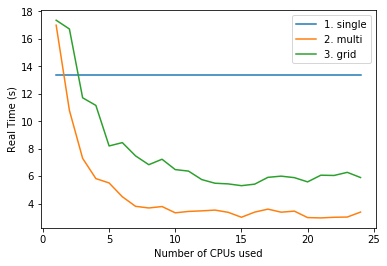

In [89]:
# real time
plt.plot(x, df_single_times['real'], label = '1. single')
plt.plot(x, df_pool_times['real'], label = '2. multi')
plt.plot(x, df_grid_times['real'], label = '3. grid')

plt.xlabel('Number of CPUs used') 
plt.ylabel('Real Time (s)')
plt.legend()
plt.savefig('img/real_time.png')
plt.show()

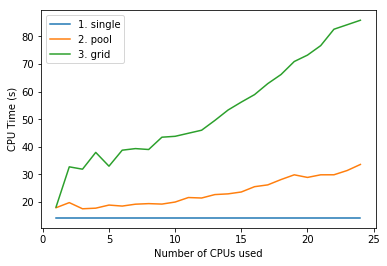

In [92]:
# CPU time
plt.plot(x, df_single_times['CPU'], label = '1. single')
plt.plot(x, df_pool_times['CPU'], label = '2. pool')
plt.plot(x, df_grid_times['CPU'], label = '3. grid')

plt.xlabel('Number of CPUs used') 
plt.ylabel('CPU Time (s)')
plt.legend()
plt.savefig('img/CPU_time.png')
plt.show()

Try the same but with 3 and 5 times more observations to see how it scales:

In [99]:
df_times = pd.DataFrame(columns = ['real','user','sys'])

for n in range(24):
    n_pool = n+1
    file = open('ServerResults/time_pool_obs%s.txt'%n_pool, 'r') 
    data = file.read()
    
    times = []
    for type in df_times.columns:
#         print(type)
        char = type+'\t'

        start_char = data.find(char) + len(char)
        t_text = data[start_char:]

        min_char = t_text.find('m')
        sec_char = t_text.find('s')
        m = float(t_text[:min_char])
        s = float(t_text[(min_char+1):sec_char])
        t = m*60 + s
        times.append(t)
#     print(df_times)
    new_t = pd.DataFrame(data =  {'real':[times[0]],'user':[times[1]],'sys':[times[2]]})
    
    df_times = df_times.append(new_t)

df_pool_obs3 = df_times.reset_index(drop = True)
df_pool_obs3['CPU'] = df_pool_obs3['user'] + df_pool_obs3['sys'] 
display(df_pool_obs3)

,real,user,sys,CPU
0,63.427,63.715,0.754,64.469
1,36.388,70.328,0.869,71.197
2,23.967,65.526,1.082,66.608
3,20.244,72.111,1.425,73.536
4,17.189,73.019,1.294,74.313
5,14.525,72.243,1.072,73.315
6,12.702,71.661,1.279,72.940
7,12.401,76.753,1.406,78.159
8,10.634,73.991,1.543,75.534
9,10.004,75.880,1.438,77.318


In [100]:
df_times = pd.DataFrame(columns = ['real','user','sys'])


for n in range(24):
    n_pool = n+1
    file = open('ServerResults/time_grid_obs%s.txt'%n_pool, 'r') 
    data = file.read()
    
    times = []
    for type in df_times.columns:
#         print(type)
        char = type+'\t'

        start_char = data.find(char) + len(char)
        t_text = data[start_char:]

        min_char = t_text.find('m')
        sec_char = t_text.find('s')
        m = float(t_text[:min_char])
        s = float(t_text[(min_char+1):sec_char])
        t = m*60 + s
        times.append(t)
#     print(df_times)
    new_t = pd.DataFrame(data =  {'real':[times[0]],'user':[times[1]],'sys':[times[2]]})
    
    df_times = df_times.append(new_t)

df_grid_obs3 = df_times.reset_index(drop = True)
df_grid_obs3['CPU'] = df_grid_obs3['user'] + df_grid_obs3['sys'] 
display(df_grid_obs3)

,real,user,sys,CPU
0,90.649,90.491,0.920,91.411
1,75.927,149.360,3.700,153.060
2,49.169,142.176,3.630,145.806
3,39.413,147.628,4.453,152.081
4,31.476,143.835,4.354,148.189
5,27.027,145.386,4.741,150.127
6,23.453,144.887,4.963,149.850
7,20.340,141.605,5.446,147.051
8,18.536,140.678,5.740,146.418
9,17.230,140.803,6.316,147.119


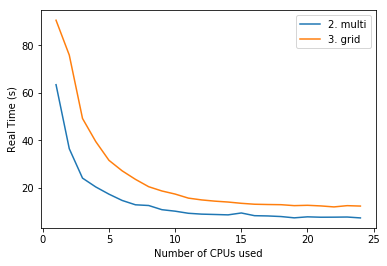

In [101]:
# real time
# plt.plot(x, df_single_times['real'], label = '1. single')
plt.plot(x, df_pool_obs3['real'], label = '2. multi')
plt.plot(x, df_grid_obs3['real'], label = '3. grid')

plt.xlabel('Number of CPUs used') 
plt.ylabel('Real Time (s)')
plt.legend()
plt.savefig('img/real_time_obs.png')
plt.show()

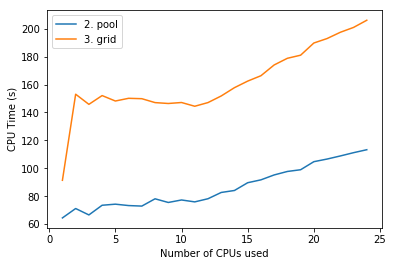

In [98]:
# CPU time
# plt.plot(x, df_single_times['CPU'], label = '1. single')
plt.plot(x, df_pool_obs3['CPU'], label = '2. pool')
plt.plot(x, df_grid_obs3['CPU'], label = '3. grid')

plt.xlabel('Number of CPUs used') 
plt.ylabel('CPU Time (s)')
plt.legend()
plt.savefig('img/CPU_time_obs.png')
plt.show()

In [102]:
df_times = pd.DataFrame(columns = ['real','user','sys'])

for n in range(24):
    n_pool = n+1
    file = open('ServerResults/time_pool_obs5%s.txt'%n_pool, 'r') 
    data = file.read()
    
    times = []
    for type in df_times.columns:
#         print(type)
        char = type+'\t'

        start_char = data.find(char) + len(char)
        t_text = data[start_char:]

        min_char = t_text.find('m')
        sec_char = t_text.find('s')
        m = float(t_text[:min_char])
        s = float(t_text[(min_char+1):sec_char])
        t = m*60 + s
        times.append(t)
#     print(df_times)
    new_t = pd.DataFrame(data =  {'real':[times[0]],'user':[times[1]],'sys':[times[2]]})
    
    df_times = df_times.append(new_t)

df_pool_obs5 = df_times.reset_index(drop = True)
df_pool_obs5['CPU'] = df_pool_obs5['user'] + df_pool_obs5['sys'] 
display(df_pool_obs5)

,real,user,sys,CPU
0,163.528,156.448,1.774,158.222
1,84.428,162.974,2.346,165.320
2,58.333,166.099,2.380,168.479
3,45.770,168.582,3.333,171.915
4,36.284,165.051,3.205,168.256
5,31.469,172.730,3.501,176.231
6,26.809,165.152,3.195,168.347
7,25.723,174.759,3.738,178.497
8,22.436,171.026,3.470,174.496
9,20.671,174.207,3.619,177.826


In [103]:
df_times = pd.DataFrame(columns = ['real','user','sys'])


for n in range(24):
    n_pool = n+1
    file = open('ServerResults/time_grid_obs5%s.txt'%n_pool, 'r') 
    data = file.read()
    
    times = []
    for type in df_times.columns:
#         print(type)
        char = type+'\t'

        start_char = data.find(char) + len(char)
        t_text = data[start_char:]

        min_char = t_text.find('m')
        sec_char = t_text.find('s')
        m = float(t_text[:min_char])
        s = float(t_text[(min_char+1):sec_char])
        t = m*60 + s
        times.append(t)
#     print(df_times)
    new_t = pd.DataFrame(data =  {'real':[times[0]],'user':[times[1]],'sys':[times[2]]})
    
    df_times = df_times.append(new_t)

df_grid_obs5 = df_times.reset_index(drop = True)
df_grid_obs5['CPU'] = df_grid_obs5['user'] + df_grid_obs5['sys'] 
display(df_grid_obs5)

,real,user,sys,CPU
0,231.687,229.873,2.568,232.441
1,123.388,242.484,3.459,245.943
2,85.015,247.090,3.881,250.971
3,67.347,255.444,4.288,259.732
4,56.226,262.422,4.313,266.735
5,47.942,266.553,4.875,271.428
6,41.683,265.467,5.532,270.999
7,39.256,284.098,5.714,289.812
8,34.955,278.402,6.211,284.613
9,32.507,278.668,6.871,285.539


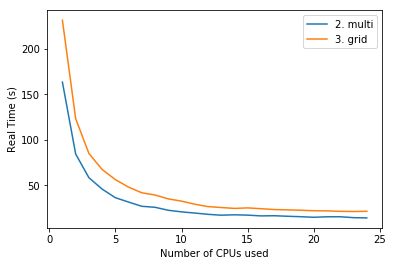

In [104]:
# real time
# plt.plot(x, df_single_times['real'], label = '1. single')
plt.plot(x, df_pool_obs5['real'], label = '2. multi')
plt.plot(x, df_grid_obs5['real'], label = '3. grid')

plt.xlabel('Number of CPUs used') 
plt.ylabel('Real Time (s)')
plt.legend()
plt.savefig('img/real_time_obs5.png')
plt.show()

## Memory profiling

We ran the following for the different methods on the server:
```py
mprof run -C -M svm_single.py 
```

We can now load the results analyse the peak memory usage:

In [42]:
import pandas as pd

#single memory profile
data = pd.read_csv('ServerResults/mprofile_single.dat')
mem_single = data.iloc[:,0].apply(lambda x: float(x.split(' ')[-2])) #no need to exclude children as we just want the max
mem_single.max()

123.367188

In [50]:
#pool memory profile
CPUs = [3,6,9,12]
mem_pool = []
for n in CPUs:
    data = pd.read_csv('ServerResults/mprofile_pool%s.dat'%n)
    mem = data.iloc[:,0].apply(lambda x: float(x.split(' ')[-2])) #no need to exclude children as we just want the max
    mem_pool.append(mem.max())

print(mem_pool)

[364.996094, 602.011719, 832.195312, 1068.308594]


In [51]:
#grid memory profile

mem_grid = []
for n in CPUs:
    data = pd.read_csv('ServerResults/mprofile_grid%s.dat'%n)
    mem = data.iloc[:,0].apply(lambda x: float(x.split(' ')[-2])) #no need to exclude children as we just want the max
    mem_grid.append(mem.max())

print(mem_grid)

[542.441406, 901.230469, 1256.921875, 1613.414062]


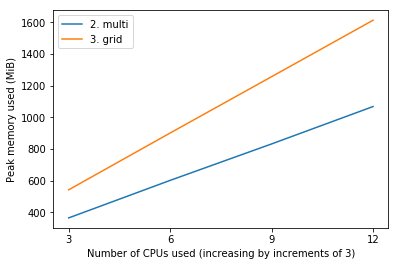

In [54]:
plt.plot(CPUs, mem_pool, label = '2. multi')
plt.plot(CPUs, mem_grid, label = '3. grid')

plt.xlabel('Number of CPUs used (increasing by increments of 3)') 
plt.xticks(CPUs)
plt.ylabel('Peak memory used (MiB)')
plt.legend()
plt.savefig('img/memory.png')
plt.show()

In [56]:
#memory usage per CPU for multiprocessing
(mem_pool - mem_single.max())/CPUs

array([80.54296867, 79.7740885 , 78.75868044, 78.74511717])

In [57]:
#memory usage per CPU for grid search
(mem_grid - mem_single.max())/CPUs

array([139.691406  , 129.64388017, 125.95052078, 124.17057283])

## At scale

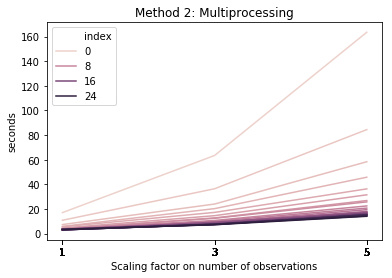

In [126]:
#for pool
df_pool_times['datasize'] = 1
df_pool_obs3['datasize'] = 3
df_pool_obs5['datasize'] = 5
df_pool_size = pd.concat([df_pool_times, df_pool_obs3, df_pool_obs5])
df_pool_size = df_pool_size.reset_index()
df_pool_size['CPU'] = df_pool_size['index']

g = sn.lineplot(x="datasize", y="real", hue = 'index', data=df_pool_size)
g.set(ylabel='seconds',xlabel='Scaling factor on number of observations')
g.set_title('Method 2: Multiprocessing')
plt.xticks(df_pool_size['datasize'])
plt.savefig('img/interaction_pool.png')
plt.show()

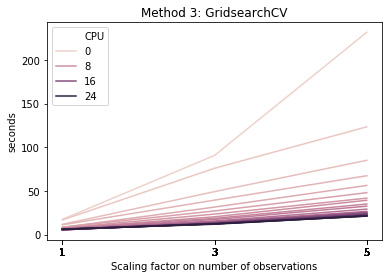

In [110]:
#for gridsearch
df_grid_times['datasize'] = 1
df_grid_obs3['datasize'] = 3
df_grid_obs5['datasize'] = 5
df_grid_size = pd.concat([df_grid_times, df_grid_obs3, df_grid_obs5])
df_grid_size = df_grid_size.reset_index()
df_grid_size['CPU'] = df_grid_size['index']+1
g = sn.lineplot(x="datasize", y="real", hue='CPU', data=df_grid_size)
g.set(ylabel='seconds',xlabel='Scaling factor on number of observations')
g.set_title('Method 3: GridsearchCV')
plt.xticks(df_pool_size['datasize'])
plt.savefig('img/interaction_grid.png')
plt.show()